# Data Engineering in Energy
### Albieri M. Alana, Estudiante de Ing Informática URBE
### 2026
***
## Week 2 Workbook
***

##**1.	Define and describe the following:**

###**a.	Feature Imputation**

Al hablar de Feature Imputation hacemos referencia a que hacer cuando tenemos valores nulos o faltantes en nuestro dataset, tenemos por ejemplo la opcion de tomar valores de tendencia central como la media para rellenarles, sin embargo, debemos tomar en cuenta que al tener outliers es posible que esos datos rellenados tengan sesgos. Otra opcion es predecirles usando regresiones lineales, bajo costo computacional sin embargo es muy sensible ya que es valga la redundancia lineal, si se quiere mayor exactitud esta el algoritmo knn que toma el promedio de los vecinos mas cercanos. Cada algoritmo tiene sus pros y contras, su implementacion dependera de las necesidades del negocio.

###**b.	Feature Transformation**

El Feature Transformation esta enfocado a la transformacion de los datos segun los requerimientos y escalas del mismo, como ejemplo tengamos una correlacion entre edad y salarios, dos tipos de enfermedades en grados o similar, basicamente comparando dos variables con cantidades medibles muy diferentes llevarles a un mismo nivel. Una de las estrategias mas famosas es la de normalizacion de min-max que consiste en llevarle de la cantidad inicial a su respectivo entre 0-1.

###**c.	Feature Ranking**

Basicamente se centra en asignar prioridades en nuestras carecteristicas para nuestro modelo, determinando cual tiene mayor importancia en comparacion a el resto, creando un "Ranking" de importancias, de la mayora a menor.

###**d.	Epistemic vs. Aleatoric Uncertainty**

Consiste en dos formas distintas de clasificar la incertidumbre, la incertidumbre epistemica tiene como base el desconocimiento. Es decir, se basa en que desconoce un hecho para calcular la incertidumbre sin emabrgo estos niveles de incertidumbre pueden bajar a medida que conozcamos mas del hecho a diferencia de la incertidumbre aleatoria que como bien dice el nombre es completamente aleatoria y fija, la misma no depende de nosotros para bajar o aumentar.

###**e.	Curse of Dimensionality**

Podemos pensar que mientras mas variables tenemos en nuestro modelo, es mejor, ¿o no?. No, por el contrario debemos calcular la cantidad viable de variables para que la misma no se vea afectada al tener pocos datos y una cantidad excesiva de varibles. Es ese concepto reside la "Curse of Dimensionality", muchas variables y pocos datos.

###**f.	Causation vs. Correlation**

Una fuerte correlacion conlleva siempre una causalidad fija cierto? No, al hablar de correlacion tomamos en cuenta que dos variables se mueven a un ritmo similar, sin embargo no siempre el hecho de A implica B. Supongamos que tenemos una fuerte correlacion entre paraguas y accidentes de vehiculos, casi de 1, eso quiere decir que los paraguas son causantes de los accidentes? no, tenemos una variable oculta en este caso la lluvia que seria la variable C quien conecta e influye en las otras 2. Para validar que dos variables con fuerte correlacion tengan causas similares se suele hacer testing A/B.

***
##**2.	Feature Imputation**

###**a.	Load the dataset as a pandas dataframe and provide a summary of the features using “pd.describe()”. How many NaN’s are there and what percent of values in the dataframe are NaNs? Pay special attention to the minimum/maximum and mean/stdv values of each feature.**

In [219]:
# Primero vamos a importar las librerias requeridas y las bases de datos

import pandas as pd

df_original = pd.read_csv("https://github.com/Albieri151/Ejercicios-Data-Science-Petroleo/raw/refs/heads/main/Week%202/unconv_MV_v2_missing.csv")
df_original.head()

,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,15.91,1.67,3.06,14.05,1.36,1.85,177.381958
1,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778
2,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583
3,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629
4,19.53,NaN,2.57,43.75,1.40,2.11,5261.094919


In [220]:
# Veremos metricas importantes como los quartiles, media y mediana ademas de la cantidad de nulos
df_original['TOC'] = df_original['TOC'].apply(lambda x: x if x > 0 else 0)
df_original.describe()

,Por,LogPerm,AI,Brittle,TOC,VR,Production
count,879.000000,911.000000,899.000000,893.000000,1000.00000,908.000000,1000.000000
mean,14.902366,1.406235,2.989911,49.424468,0.91079,1.987720,2247.295809
std,3.032083,0.407736,0.571529,14.929853,0.55740,0.311833,1464.256312
min,5.400000,0.120000,1.210000,3.030000,0.00000,0.930000,2.713535
25%,12.790000,1.140000,2.580000,39.390000,0.48000,1.800000,1191.369560
50%,14.980000,1.390000,3.010000,49.440000,0.93000,1.990000,1976.487820
75%,17.060000,1.680000,3.375000,58.890000,1.33000,2.172500,3023.594214
max,24.650000,2.580000,4.700000,93.470000,2.71000,2.900000,12568.644130


In [221]:
# Que pocentaje de valores son nan por cada feature
features = df_original.columns
headers = ["Feature", "Missing Values", "% of Total Values"]
df_nan_features = df_original[features].isna().sum() / len(df_original) * 100
df_nan_features = pd.DataFrame({"Missing Values": df_original[features].isna().sum(), "% of Total Values": df_nan_features})
df_nan_features

,Missing Values,% of Total Values
Por,121,12.1
LogPerm,89,8.9
AI,101,10.1
Brittle,107,10.7
TOC,0,0.0
VR,92,9.2
Production,0,0.0


### **b.	Consider the following imputation methods: (A) Global mean, (B) Nearest Neighbor, (C) k-Nearest Neighbors, (D) Last Observation Carried Forward.**

In [222]:
# Tenemos muchos outliers, ademas de valores nulos o irregulares como el vaso de valores negativos en TOC (Carbono Orgánico Total)
# Vamos a limpiar y reorganizar los datos
# Primero usaremos el metodo de promedio global (Sacaremos los outliers para evitar sesgos en nuestro promedio y tratar de que nuestro promedio sea mas acertado)

In [223]:
#Calculamos el iqr para todos los features
iqr = df_original.quantile(0.75) - df_original.quantile(0.25)
iqr

,0
Por,4.270000
LogPerm,0.540000
AI,0.795000
Brittle,19.500000
TOC,0.850000
VR,0.372500
Production,1832.224654


In [224]:
#Calculamos los limites y despues limpiamos el df de forma temporal
limites_superiores = df_original.quantile(0.75) + 1.5 * iqr
limites_inferiores = df_original.quantile(0.25) - 1.5 * iqr

df_datos_promedio = df_original[~((df_original < (limites_inferiores)) |(df_original > (limites_superiores)))]
df_datos_promedio.describe()

,Por,LogPerm,AI,Brittle,TOC,VR,Production
count,875.000000,900.000000,893.000000,887.000000,999.000000,893.000000,976.000000
mean,14.902274,1.405167,2.990112,49.337880,0.908989,1.988891,2130.539909
std,2.972704,0.389516,0.556496,14.549987,0.554761,0.294015,1256.610349
min,6.480000,0.360000,1.390000,10.940000,0.000000,1.250000,2.713535
25%,12.815000,1.140000,2.580000,39.390000,0.480000,1.800000,1178.482548
50%,14.980000,1.390000,3.010000,49.410000,0.930000,1.990000,1949.171855
75%,17.055000,1.680000,3.360000,58.830000,1.330000,2.170000,2922.440884
max,23.310000,2.480000,4.520000,87.600000,2.560000,2.720000,5730.401418


In [225]:
#Comparamos con los datos originales
df_original.describe()

,Por,LogPerm,AI,Brittle,TOC,VR,Production
count,879.000000,911.000000,899.000000,893.000000,1000.00000,908.000000,1000.000000
mean,14.902366,1.406235,2.989911,49.424468,0.91079,1.987720,2247.295809
std,3.032083,0.407736,0.571529,14.929853,0.55740,0.311833,1464.256312
min,5.400000,0.120000,1.210000,3.030000,0.00000,0.930000,2.713535
25%,12.790000,1.140000,2.580000,39.390000,0.48000,1.800000,1191.369560
50%,14.980000,1.390000,3.010000,49.440000,0.93000,1.990000,1976.487820
75%,17.060000,1.680000,3.375000,58.890000,1.33000,2.172500,3023.594214
max,24.650000,2.580000,4.700000,93.470000,2.71000,2.900000,12568.644130


In [226]:
#Creamos el df con los valores imputados usando una media sin outliers

df_datos_imputados_media = df_original.fillna(df_datos_promedio.mean())

df_datos_imputados_media.describe()

,Por,LogPerm,AI,Brittle,TOC,VR,Production
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,14.902355,1.406140,2.989931,49.415203,0.91079,1.987828,2247.295809
std,2.842534,0.389150,0.541868,14.107693,0.55740,0.297128,1464.256312
min,5.400000,0.120000,1.210000,3.030000,0.00000,0.930000,2.713535
25%,13.110000,1.160000,2.630000,40.600000,0.48000,1.820000,1191.369560
50%,14.902274,1.405167,2.990112,49.337880,0.93000,1.988891,1976.487820
75%,16.772500,1.660000,3.330000,57.865000,1.33000,2.160000,3023.594214
max,24.650000,2.580000,4.700000,93.470000,2.71000,2.900000,12568.644130


In [227]:
"""
Visto el metodo de imputacion en base al promedio, tratamos de hacerlo lo mas acertado
posible quitando outliers ahora probaremos el metodo k-Nearest Neighbors, nos saltamos el
Nearest Neighbors ya que es una variacion limitada a una sola fila que podria ser de un
outlier y el metodo de Last Observation Carried Forward ya que no tenemos un orden exacto
"""
#Primero vamos a importar la libreria necesaria para abstraernos de realizar el calculo de forma manual
from sklearn.impute import KNNImputer

# Le decimos al algoritmo que use 31 vecinos (la raíz cuadrada impar del total de filas)
imputador_final = KNNImputer(n_neighbors=31)

df_datos_imputados_knn = imputador_final.fit_transform(df_original)

# Comprobamos que ya no existan valores nulos (NaN) en toda la tabla
df_datos_imputados_knn = pd.DataFrame(df_datos_imputados_knn, columns=df_original.columns)
df_datos_imputados_knn.describe()


,Por,LogPerm,AI,Brittle,TOC,VR,Production
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,14.900914,1.401902,2.988548,49.503106,0.91079,1.987578,2247.295809
std,2.950962,0.395924,0.546425,14.147778,0.55740,0.298133,1464.256312
min,5.400000,0.120000,1.210000,3.030000,0.00000,0.930000,2.713535
25%,12.827500,1.140000,2.612661,40.600000,0.48000,1.819435,1191.369560
50%,14.920000,1.390000,3.010000,49.205000,0.93000,2.000000,1976.487820
75%,17.050323,1.680000,3.330000,57.995000,1.33000,2.160000,3023.594214
max,24.650000,2.580000,4.700000,93.470000,2.71000,2.900000,12568.644130


In [228]:
# En este df vamos a sacar la caracteristica Production para evitar sesgos si queremos predecir mas adelante esta varible en comparacion con la anterior al imputarle usando K vecinos cercanos

df_datos_imputados_knn_sin_prod =  imputador_final.fit_transform(df_original.drop(columns=['Production']))
df_datos_imputados_knn_sin_prod = pd.DataFrame(df_datos_imputados_knn_sin_prod, columns=df_original.drop(columns=['Production']).columns)
df_datos_imputados_knn_sin_prod['Production'] = df_original['Production']
df_datos_imputados_knn_sin_prod.describe()

,Por,LogPerm,AI,Brittle,TOC,VR,Production
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,14.911129,1.402911,2.993263,49.390324,0.91079,1.991794,2247.295809
std,2.895611,0.392724,0.546105,14.168601,0.55740,0.298515,1464.256312
min,5.400000,0.120000,1.210000,3.030000,0.00000,0.930000,2.713535
25%,12.917500,1.150000,2.627500,40.567500,0.48000,1.820000,1191.369560
50%,14.937097,1.390000,3.010000,49.220000,0.93000,2.004194,1976.487820
75%,16.890000,1.670000,3.330000,57.970000,1.33000,2.160000,3023.594214
max,24.650000,2.580000,4.700000,93.470000,2.71000,2.900000,12568.644130


In [229]:
#Demostramos numericamente que el metodo KNN es mas efectivo ya que mantiene la std de nuestros datos originales de una forma mas consistente
comparativa = pd.DataFrame({
    'Original': df_original['Por'].describe(),
    'Media Global': df_datos_imputados_media['Por'].describe(),
    'KNN (k=31) con Produccion': df_datos_imputados_knn['Por'].describe(),
    'KNN (k=31) sin Produccion': df_datos_imputados_knn_sin_prod['Por'].describe()
})
comparativa

,Original,Media Global,KNN (k=31) con Produccion,KNN (k=31) sin Produccion
count,879.000000,1000.000000,1000.000000,1000.000000
mean,14.902366,14.902355,14.900914,14.911129
std,3.032083,2.842534,2.950962,2.895611
min,5.400000,5.400000,5.400000,5.400000
25%,12.790000,13.110000,12.827500,12.917500
50%,14.980000,14.902274,14.920000,14.937097
75%,17.060000,16.772500,17.050323,16.890000
max,24.650000,24.650000,24.650000,24.650000


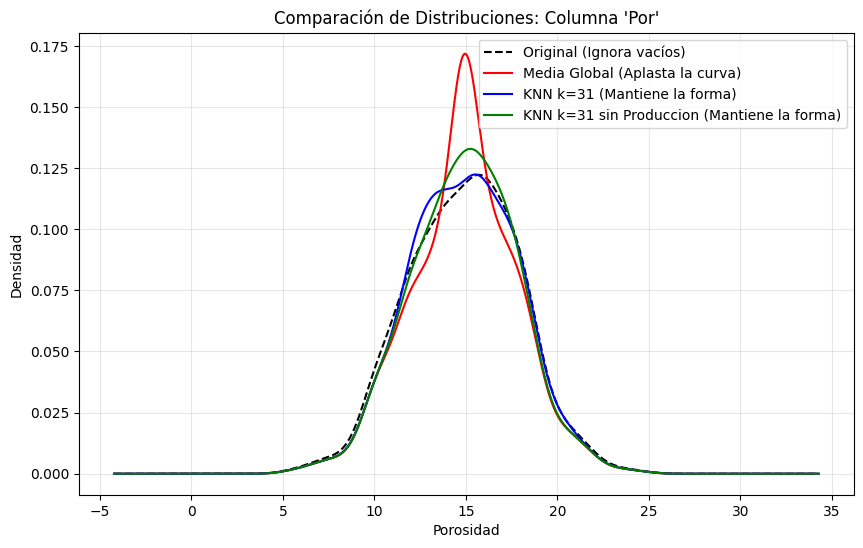

In [230]:
#Demostramos graficamente nuestros resultados.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Dibujamos la "montaña" de cada conjunto de datos
df_original['Por'].plot(kind='kde', color='black', linestyle='--', label='Original (Ignora vacíos)')
df_datos_imputados_media['Por'].plot(kind='kde', color='red', label='Media Global (Aplasta la curva)')
df_datos_imputados_knn['Por'].plot(kind='kde', color='blue', label='KNN k=31 (Mantiene la forma)')
df_datos_imputados_knn_sin_prod['Por'].plot(kind='kde', color='green', label='KNN k=31 sin Produccion (Mantiene la forma)')

# Detalles estéticos
plt.title("Comparación de Distribuciones: Columna 'Por'")
plt.xlabel("Porosidad")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

### **c.	Compare the different methods and choose the best one (and justify).**

#### Como mencione en la seccion 2, compare entre solo 2 metodos de los 4 propuestos, el 4to no fue usado porque no tenemos ninguna temporalidad o contexto del mismo, el dos fue descartado porque aunque pueda tener mejor std, podria pasar que se sesgue con valores atipicos de otras filas, quedando solo con el de media general y K vecinos mas cercanos

**Media General:** Este metodo apilo una serie de datos todos iguales por su naturaleza de un solo numero (la media) para sustituir en todos los valores faltantes lo cual para un modelo podria sesgarle ya que la cantidad faltante de numeros es amplia

**K vecinos mas cercanos:** Usamos este metodo por ser mas efectivo para darle continuidad a los datos originales, a diferencia del metodo de una unica fila parecida este usa varias lo cual nos da mayor seguridad al momento imputar datos.

### **d. Create a 1xN_features scatterplot of each feature against Production from the imputed dataframe. Include axes labels, titles, legend, or any other necessary attributes of an informative plot.**

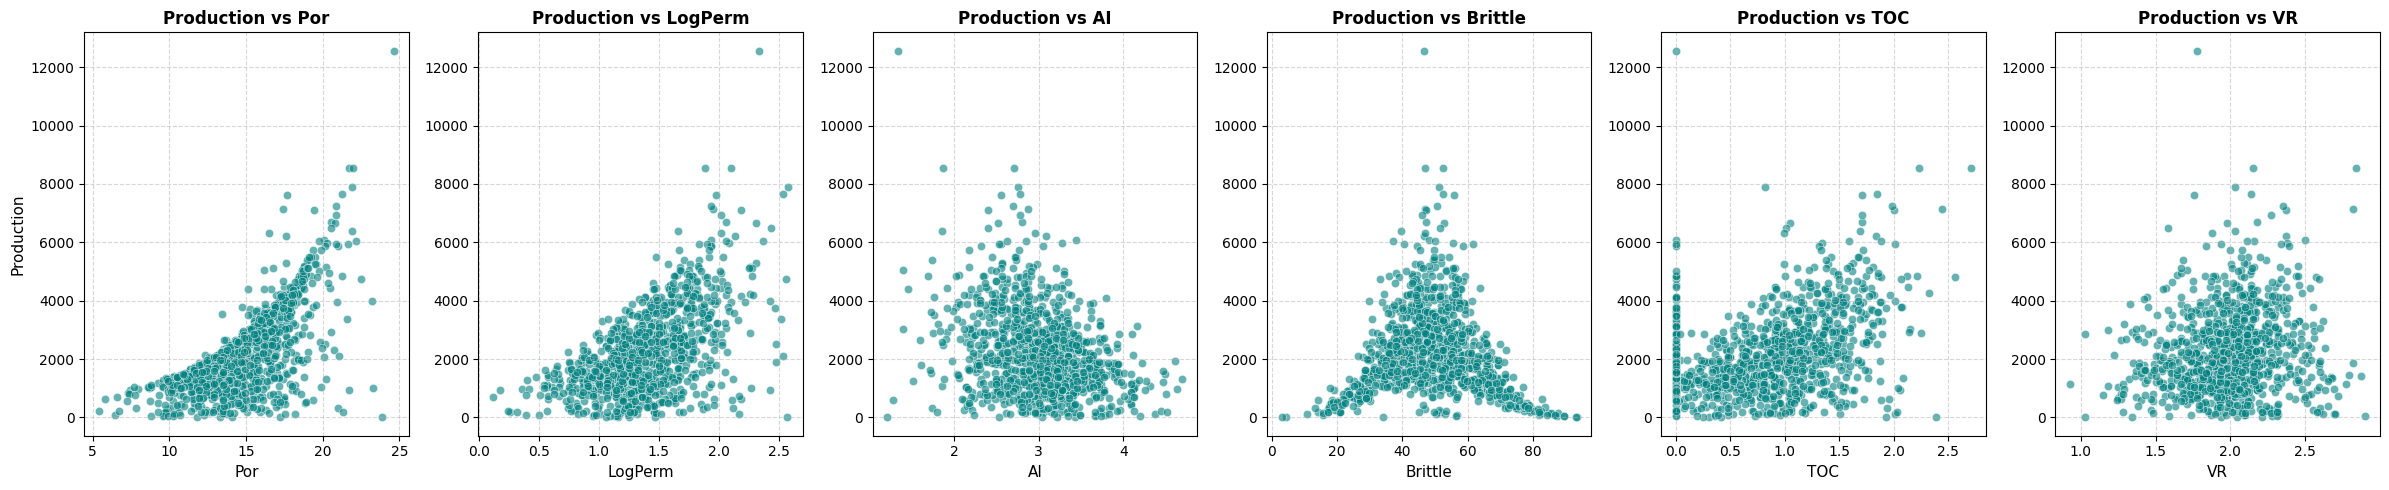

In [231]:
features = features[:-1]

# 4. Crear la figura y los subgráficos (1 fila, 6 columnas)
fig, axes = plt.subplots(1, len(features), figsize=(24, 5))

for i, feature in enumerate(features):
    # Crear el gráfico de dispersión individual
    axes[i].scatter(df_datos_imputados_knn_sin_prod[feature], df_datos_imputados_knn_sin_prod['Production'],
                    alpha=0.6, color='teal', edgecolors='white', linewidth=0.5)

    # Atributos del gráfico (Títulos, etiquetas y cuadrículas)
    axes[i].set_title(f"Production vs {feature}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=11)

    # Solo poner etiqueta 'Y' en el primer gráfico a la izquierda para mantener la limpieza
    if i == 0:
        axes[i].set_ylabel("Production", fontsize=11)

    # Añadir cuadrícula
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Ajustar diseño automáticamente para que nada se superponga
plt.tight_layout()
plt.savefig('scatterplots.png', transparent=True, facecolor='w', bbox_inches='tight')
plt.show()

#


### **e.	Do you notice any spurious imputed values, and if so, why do you think they occur?**

#### Si, en primer momento cree la grafica incluyendo la variable de produccion para el calculo lo cual me produjo valores espurios, datos falsos o sesgados al momento de intentar a futuro usar estos valores para predecir producciones.

#### Podemos notarlo si en el punto D cambiamos el df de sin produccion a con produccion, las correlaciones de Por en funcion de la produccion se ven afectadas, no solo ella tambien en base al LogPerm, en general todos sufrieron un fuerte impacto.

## **3.	Feature Transformations**

### **a.	Use the imputed dataframe based on the method you selected above.**

In [232]:
df_datos_imputados_knn_sin_prod.describe()

,Por,LogPerm,AI,Brittle,TOC,VR,Production
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,14.911129,1.402911,2.993263,49.390324,0.91079,1.991794,2247.295809
std,2.895611,0.392724,0.546105,14.168601,0.55740,0.298515,1464.256312
min,5.400000,0.120000,1.210000,3.030000,0.00000,0.930000,2.713535
25%,12.917500,1.150000,2.627500,40.567500,0.48000,1.820000,1191.369560
50%,14.937097,1.390000,3.010000,49.220000,0.93000,2.004194,1976.487820
75%,16.890000,1.670000,3.330000,57.970000,1.33000,2.160000,3023.594214
max,24.650000,2.580000,4.700000,93.470000,2.71000,2.900000,12568.644130


### **b.	Consider the following transformation methods: (A) Truncation, (B) Standardization, (C) Min-Max.**

***
# END